# Title: Natural Language Processing with Disaster Tweets
* Goal: Predict which Tweets are about real disasters and which ones are not
* Link: https://www.kaggle.com/competitions/nlp-getting-started

Code links: 
1. https://www.kaggle.com/code/sandragracenelson/disaster-tweets-prediction
2. https://www.kaggle.com/code/shubhamchandrakar17/disaster-prediction-using-tweets-basic-nlp
3. https://www.kaggle.com/code/zinebkhanjari/disaster-tweets-multiple-vectorizers-and-models#Vectorisation

# Problem Statement : Predict disaster using tweets

Steps to build a good model:

**1. Loading Data:** Load data into dataframe

**2. Data Wrangling:** Peform data wrangling to clean raw data. 
- Check for null/nan and treat it
- Drop duplicates
- Drop unrelevent features

**3. Data pre-processing:**
- Remove stop words
- Remove punctuation marks
- Convert text into lowercase
- Create Word cloud to understand type of words occuring more frequently in data

**4. Building model**
- Perform test train split
- Build multiple models---> Evalute model ----> Tune models

**5. Check final scores of all models**

**6. Pick best model with highest f1 score**

**7. Download data to csv for submission**

# Importing libraries

In [29]:
#Importing required libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import seaborn as sns
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from textblob import TextBlob, Word
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

## # Helper Functions

In [3]:
def plot_cm(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    plt.show()
    print(classification_report(y_test, y_pred))

In [4]:
# remove puntucation marks
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [5]:
def lem(text):
    '''takes words and return word after stemming'''
    
    list_empty=[]
    
    for i in text.split():
        w = Word(i)
        
        list_empty.append(w.lemmatize())
    #convert list to string
    string = " ".join(list_empty)
    
    return string

In [6]:
def cal_scores(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    return accuracy,f1,recall,precision

# Exploratory Data Analysis

## Load data

In [177]:
#Loading the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Keyword
What are some of the most commonly used keywords?

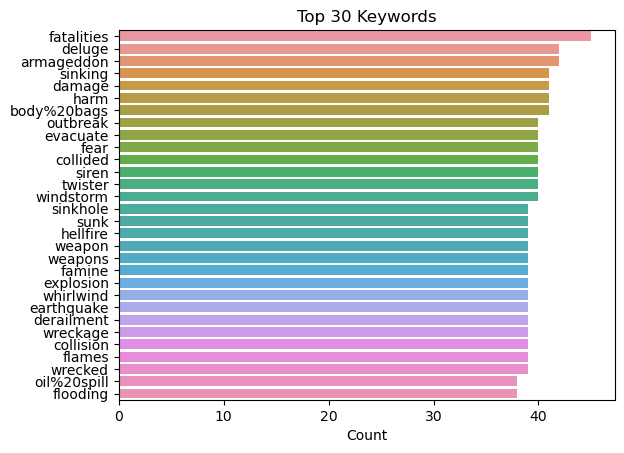

In [178]:
keywords_vc = pd.DataFrame({"Count": train["keyword"].value_counts()})
sns.barplot(y=keywords_vc[0:30].index, x=keywords_vc[0:30]["Count"], orient='h')
plt.title("Top 30 Keywords")
plt.show()

In [179]:
len(train["keyword"].value_counts())

221

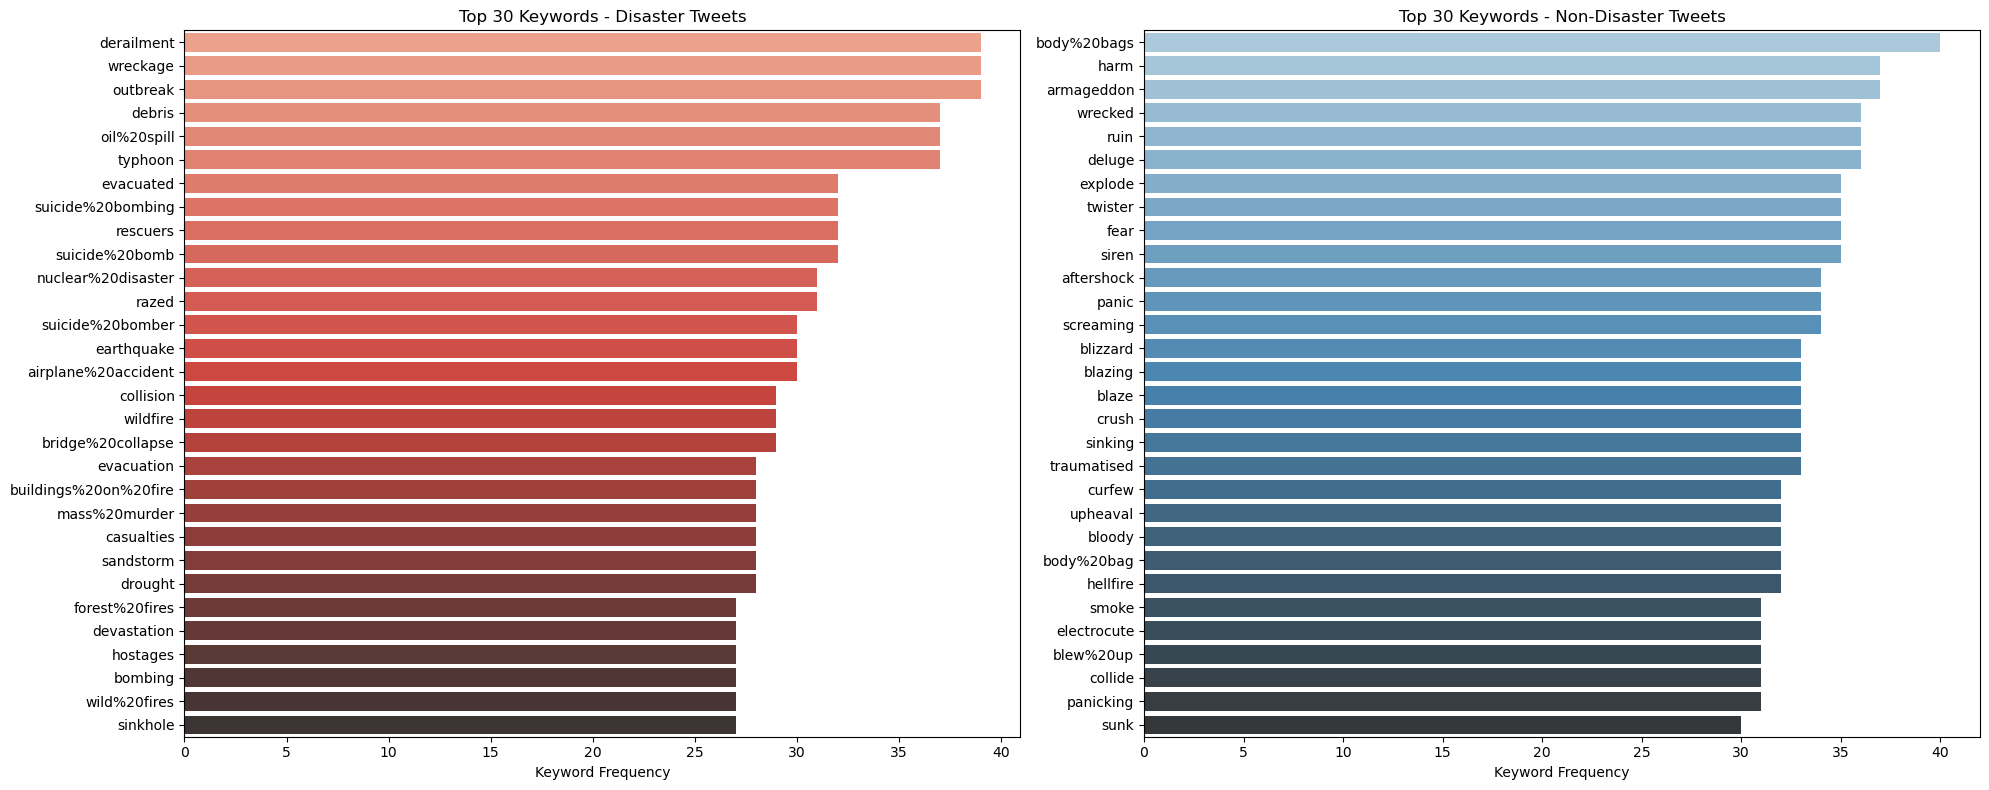

In [180]:
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:30].index, x=disaster_keywords[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_keywords[0:30].index, x=nondisaster_keywords[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

keyword = 'armageddon'

In [181]:
armageddon_tweets = train[(train["keyword"].fillna("").str.contains("armageddon")) & (train["target"] == 0)]
print("An example tweet:\n", armageddon_tweets.iloc[10, 3])
armageddon_tweets.head()

An example tweet:
 @ENews Ben Affleck......I know there's a wife/kids and other girls but I can't help it. I've loved him since Armageddon #eonlinechat


,id,keyword,location,text,target
304,446,armageddon,"California, United States",#PBBan (Temporary:300) avYsss @'aRmageddon | D...,0
305,447,armageddon,"California, United States",#PBBan (Temporary:300) Russaky89 @'aRmageddon ...,0
306,448,armageddon,#FLIGHTCITY UK,((OFFICIAL VID)) #DoubleCups &gt;&gt; https://...,0
307,450,armageddon,NaN,ouvindo Peace Love &amp; Armageddon,0
308,451,armageddon,NaN,Best movie you've ever seen? - Armageddon htt...,0


In [183]:
def keyword_disaster_probabilities(x):
    tweets_w_keyword = np.sum(train["keyword"].fillna("").str.contains(x))
    tweets_w_keyword_disaster = np.sum(train["keyword"].fillna("").str.contains(x) & train["target"] == 1)
    return tweets_w_keyword_disaster / tweets_w_keyword

keywords_vc["Disaster_Probability"] = keywords_vc.index.map(keyword_disaster_probabilities)
keywords_vc.head()

,Count,Disaster_Probability
fatalities,45,0.577778
deluge,42,0.188406
armageddon,42,0.119048
sinking,41,0.195122
damage,41,0.463415


In [185]:
keywords_vc.sort_values(by="Disaster_Probability", ascending=False).head(10)

,Count,Disaster_Probability
derailment,39,1.000000
debris,37,1.000000
wreckage,39,1.000000
outbreak,40,0.975000
typhoon,38,0.973684
oil%20spill,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.951613
suicide%20bomb,35,0.949495


In [186]:
keywords_vc.sort_values(by="Disaster_Probability").head(10)

,Count,Disaster_Probability
aftershock,34,0.000000
body%20bags,41,0.024390
ruin,37,0.027027
blazing,34,0.029412
screaming,36,0.055556
traumatised,35,0.057143
blew%20up,33,0.060606
panicking,33,0.060606
blight,32,0.062500
body%20bag,33,0.065421


## Location

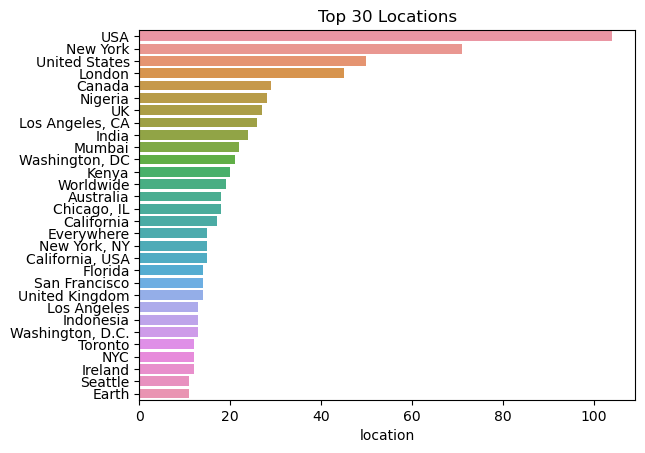

In [188]:
locations_vc = train["location"].value_counts()
sns.barplot(y=locations_vc[0:30].index, x=locations_vc[0:30], orient='h')
plt.title("Top 30 Locations")
plt.show()

In [189]:
len(train["location"].value_counts())


3341

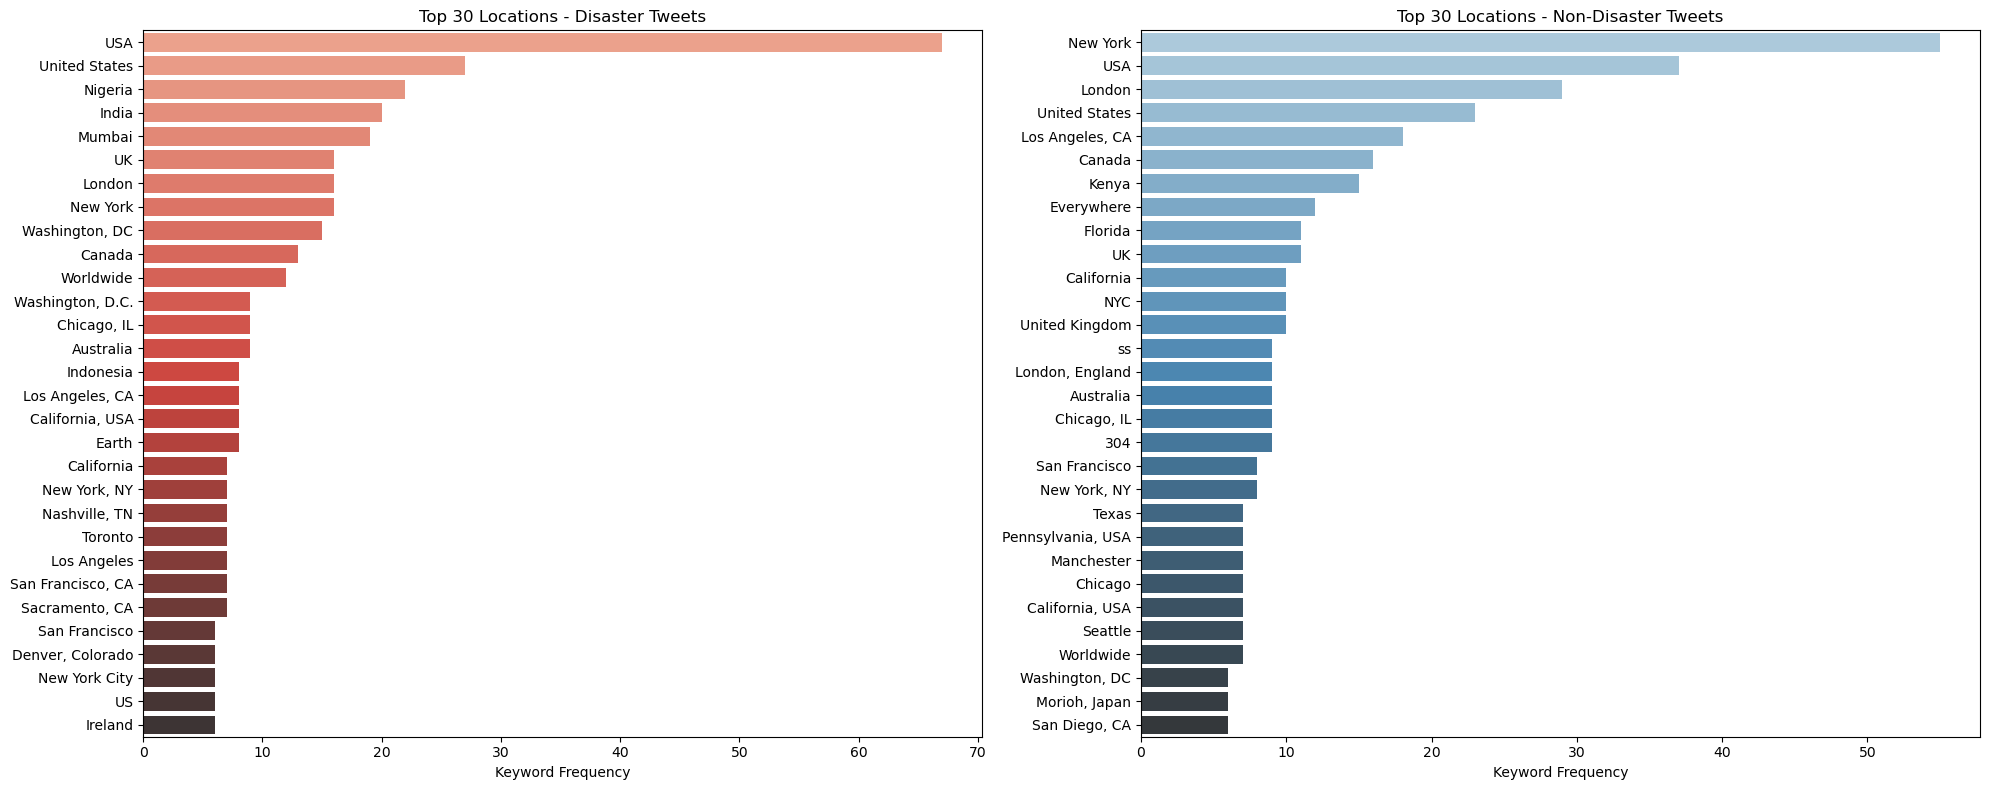

In [190]:
disaster_locations = train.loc[train["target"] == 1]["location"].value_counts()
nondisaster_locations = train.loc[train["target"] == 0]["location"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_locations[0:30].index, x=disaster_locations[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_locations[0:30].index, x=nondisaster_locations[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Locations - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Locations - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

## Text aka Tweet Content

### tweet length distribution

/var/folders/jx/xbdjzsxn7jgbrsvmdjdknjp40000gn/T/ipykernel_12898/2622330924.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["tweet_length"])


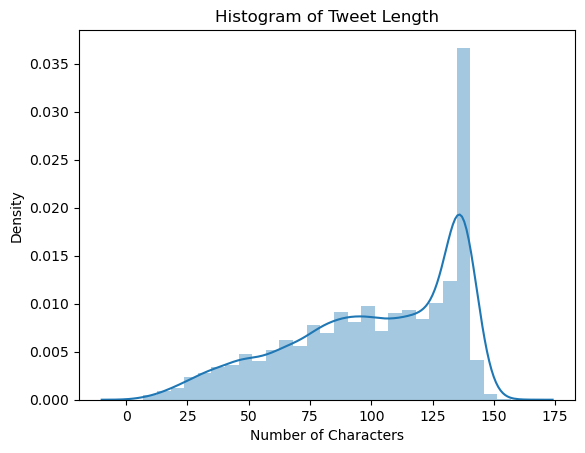

In [192]:
train["tweet_length"] = train["text"].apply(len)
sns.distplot(train["tweet_length"])
plt.title("Histogram of Tweet Length")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

In [194]:
min(train["tweet_length"]), max(train["tweet_length"])


(7, 157)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


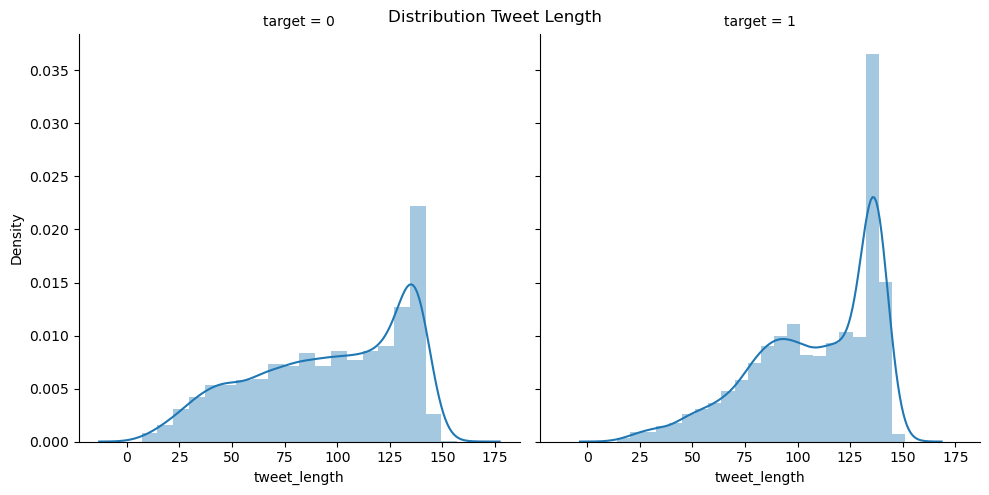

In [195]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "tweet_length")
plt.suptitle("Distribution Tweet Length")
plt.show()

### Number of Words¶


/var/folders/jx/xbdjzsxn7jgbrsvmdjdknjp40000gn/T/ipykernel_12898/1580035178.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["num_words"], bins=10)


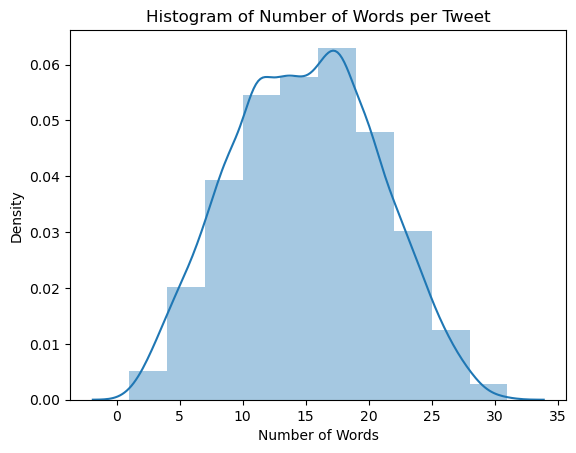

In [197]:
def count_words(x):
    return len(x.split())

train["num_words"] = train["text"].apply(count_words)
sns.distplot(train["num_words"], bins=10)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


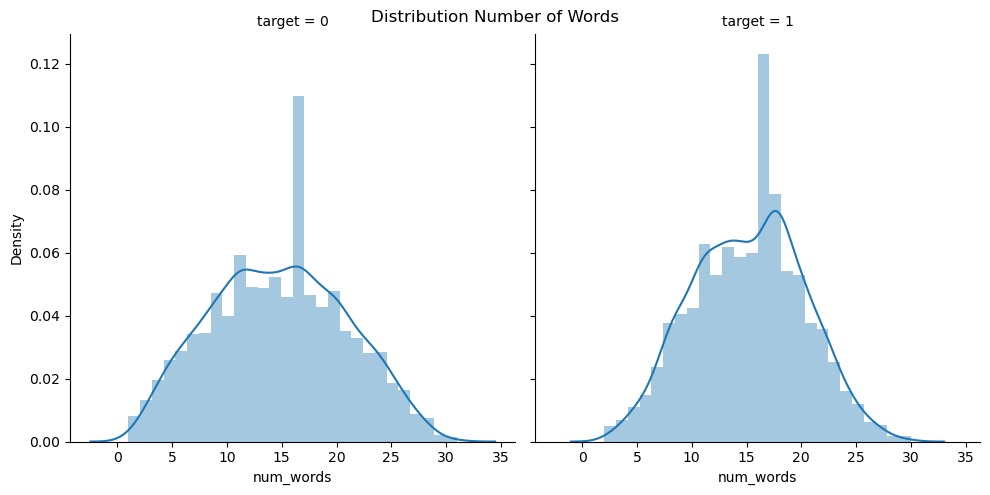

In [198]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "num_words")
plt.suptitle("Distribution Number of Words")
plt.show()

# **STEP 1: Loading Data**

## Load data

In [175]:
#Loading the data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [169]:
#Viewing the data for training
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# **Step 2: Data Wrangling**
* Peform data wrangling to clean raw data.
    1. Check for null/nan and treat it
    2. Drop duplicates
    3. Drop unrelevent features

## Shape of data

In [170]:
train_data.shape

(7613, 5)

## Check for null values

In [12]:
# check for null values

train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [15]:
# We will drop location because 33.2% data is null
#location will not be good parameter due to too much nulln values

train_data.location.isnull().sum()/len(train_data)

0.33272034677525286

In [19]:
#Removing irrelevant columns
train_data.drop(columns=['keyword', 'location'], inplace = True)
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
test_data.drop(columns=['keyword', 'location'], inplace = True)
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In the target column, '0' indicates it is not a tweet related to disaster

0    4342
1    3271
Name: target, dtype: int64


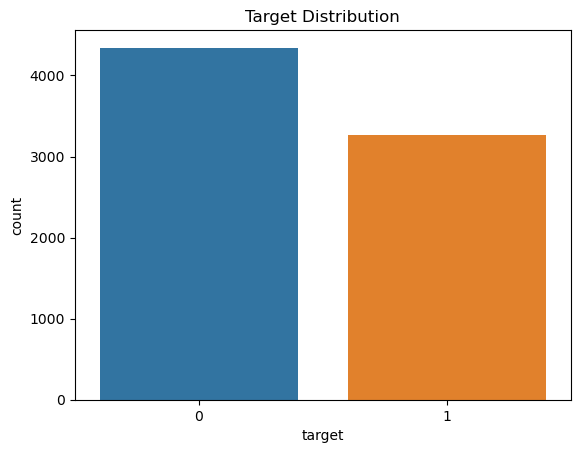

In [21]:
#Let's check the distributaion of target variable.
sns.countplot(x='target', data=train_data,)
plt.title('Target Distribution');

print(train_data['target'].value_counts())

# **STEP 3: Data Pre-Processing**

In [40]:
train_data['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

## Remove puntucation marks 

In [42]:
# remove puntucation marks
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [44]:
train_data['text'] = train_data['text'].apply(remove_punctuations)

test_data['text'] = test_data['text'].apply(remove_punctuations)

In [46]:
train_data['text'][0]

'Our Deeds are the Reason of this earthquake May ALLAH Forgive us all'

In [45]:
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this earthquake Ma...,1
1,4,Forest fire near La Ronge Sask Canada,1
2,5,All residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,Just got sent this photo from Ruby Alaska as s...,1


## remove stopwords and convert letters into lowercase

In [48]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [27]:
#Viewing stop words
", ".join(english_stopwords)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [50]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in (stop_words)]))

test_data['text'] = test_data['text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in (stop_words)]))

In [51]:
train_data['text'][0]

'our deeds reason earthquake may allah forgive us'

## Create Word cloud to understand type of words occuring more frequently in data

- To check density of words
- To examine what this tweets are mostly saying

target = 1

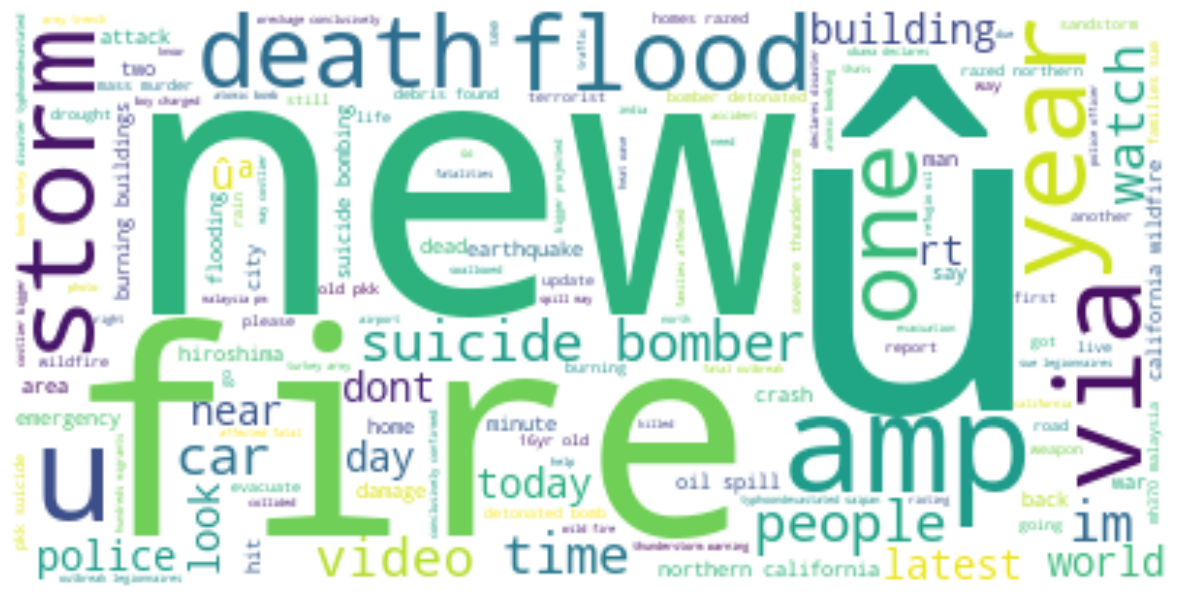

In [54]:
text = " ".join(i for i in train_data[train_data['target']==1].text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

target = 0

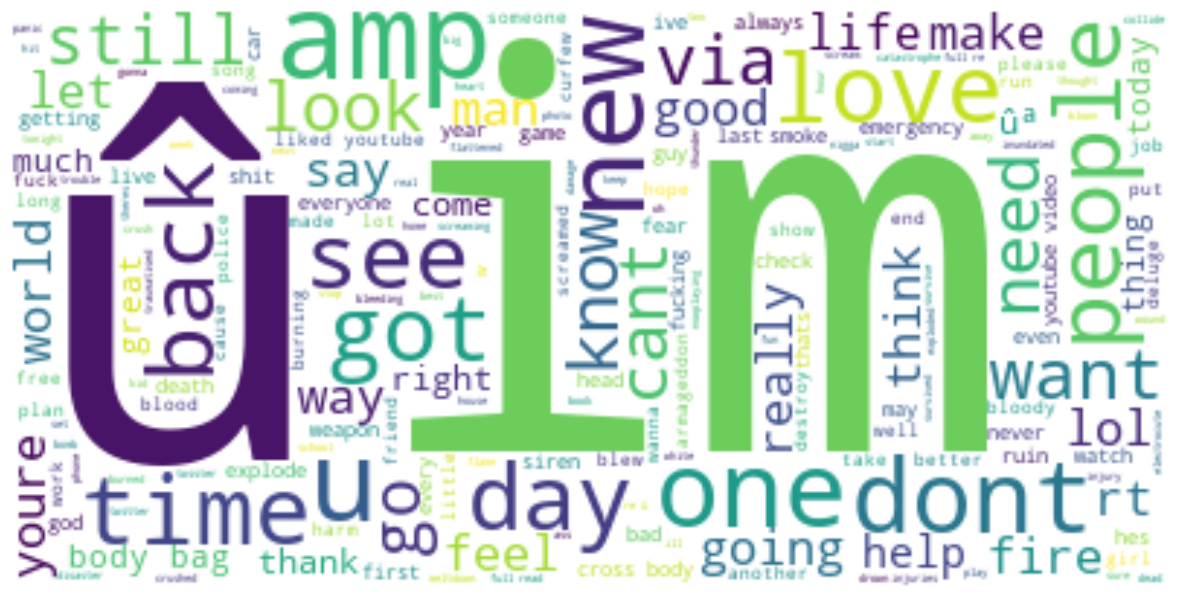

In [56]:
text = " ".join(i for i in train_data[train_data['target']==0].text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

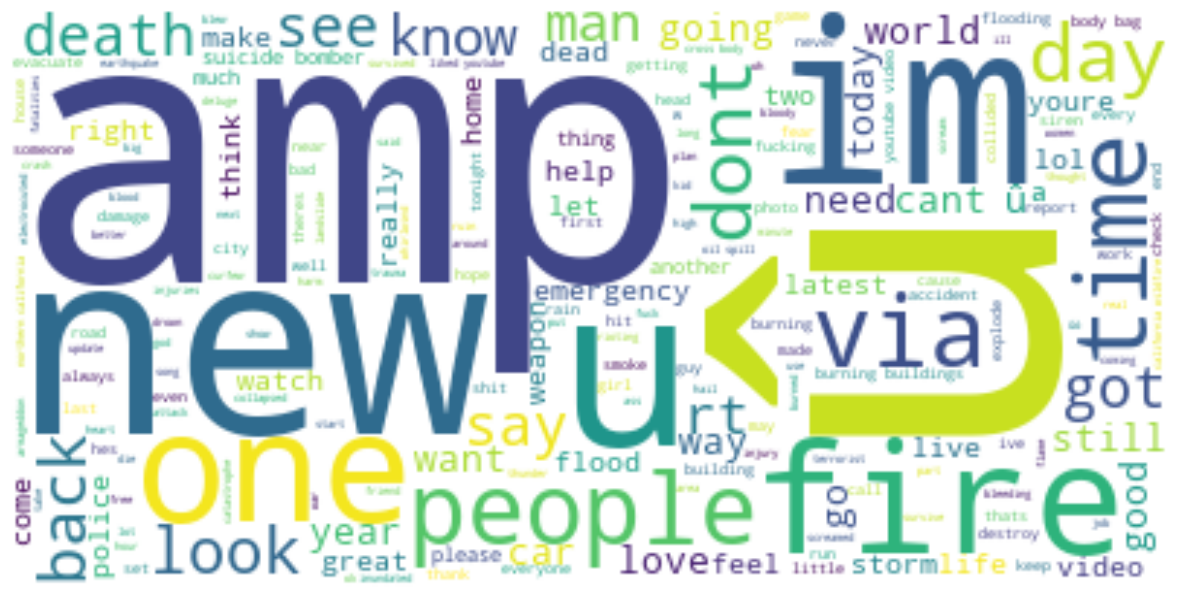

In [59]:
text = " ".join(i for i in train_data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [62]:
"".join(train_data['text'][0])

'our deeds reason earthquake may allah forgive us'

## Lemmatization 词形还原

In [ ]:
from textblob import TextBlob, Word

In [64]:
#performing stemming in df

train_data['text']= train_data['text'].apply(lem)

test_data['text']= test_data['text'].apply(lem)

In [65]:
#top 10 rows in train set after lemmetization
train_data.head(10)

,id,text,target
0,1,our deed reason earthquake may allah forgive u,1
1,4,forest fire near la ronge sask canada,1
2,5,all resident asked shelter place notified offi...,1
3,6,13000 people receive wildfire evacuation order...,1
4,7,just got sent photo ruby alaska smoke wildfire...,1
5,8,rockyfire update california hwy 20 closed dire...,1
6,10,flood disaster heavy rain cause flash flooding...,1
7,13,im top hill i see fire wood,1
8,14,there emergency evacuation happening building ...,1
9,15,im afraid tornado coming area,1


In [66]:
# first row of tag column after stemming
train_data['text'][0]

'our deed reason earthquake may allah forgive u'

## Stemming 词干提取

In [68]:
from nltk.stem.porter import *
ps = PorterStemmer()

In [70]:
# example how stemming works
ps.stem('Loving')

'love'

In [77]:
def stem(text):
    '''takes words and return word after stemming'''
    
    list_empty=[]
    
    for i in text.split():
        
        list_empty.append(ps.stem(i))
#     covert list to string
    string = " ".join(list_empty)
    
    return string

In [81]:
#performing stemming in df

train_data['tags']= train_data['text'].apply(stem)


test_data['tags']= test_data['text'].apply(stem)

In [84]:
train_data['tags'][0]

'our deed reason earthquak may allah forgiv u'

## Checking distribution of target variable

In [96]:
train_data.groupby(['target']).count()

,id,text,tags
target,,,
0,4342,4342,4342
1,3271,3271,3271


0    4342
1    3271
Name: target, dtype: int64


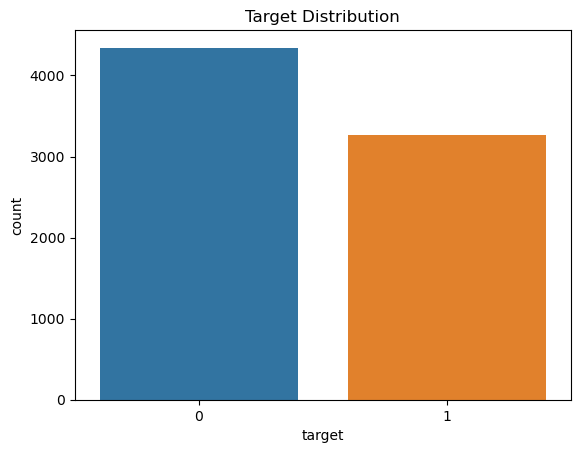

In [97]:
#Let's check the distributaion of target variable.
sns.countplot(x='target', data=train_data,)
plt.title('Target Distribution');

print(train_data['target'].value_counts())

## Making Bag of Words

* It’s an algorithm that transforms the text into fixed-length vectors. This is possible by counting the number of times the word is present in a document. The word occurrences allow to compare different documents and evaluate their similarities for applications, such as search, document classification, and topic modeling.

* The reason for its name, “Bag-Of-Words”, is due to the fact that it represents the sentence as a bag of terms. It doesn’t take into account the order and the structure of the words, but it only checks if the words appear in the document.

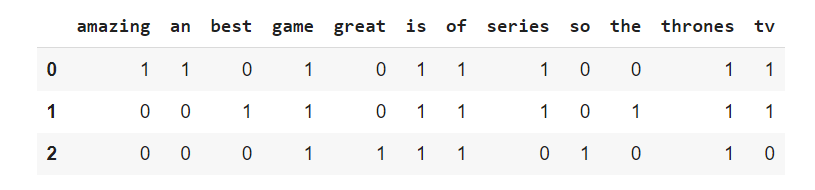


In [109]:
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 5000)

X = vectorizer.fit_transform(train_data['text'])

T = vectorizer.transform(test_data['text'])

In [113]:
#shape of sparse matrix
X.shape

(7613, 5000)

In [114]:
#check features name
vectorizer.get_feature_names_out()

array(['0104', '010401', '02', ..., 'ûïwhen', 'ûò', 'ûó'], dtype=object)

In [115]:
X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.54963563, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# **STEP 4: Building Model**

In [14]:
#Importing required libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [116]:
#Assigning data to dependent var and independent var

# X convert to sparse matrix
X = X.toarray()

#y target variable
y = train_data['target'].values

In [117]:
X.shape

(7613, 5000)

In [118]:
y.shape

(7613,)

## Splitting data

In [121]:
# shape of X
print(f'shape of x is {X.shape}')

# shape of y
print(f'shape of y is {y.shape}')

shape of x is (7613, 5000)
shape of y is (7613,)


In [122]:
#splitting data into train set i.e. validation set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Building models

### Logistic regression

In [126]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression()

In [127]:
#model score on train set

lr.score(X_train,y_train)

0.8686371100164204

In [128]:
#model score on test set

lr.score(X_test,y_test)

0.8824688115561392

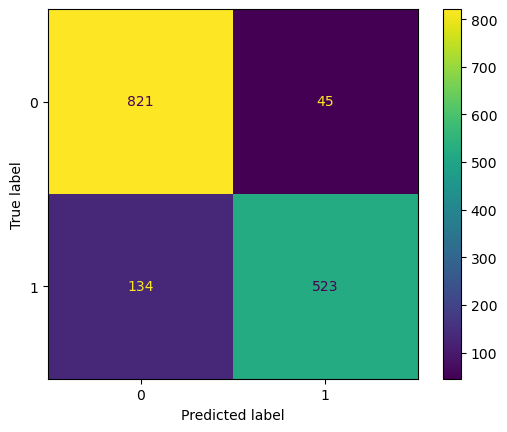

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       866
           1       0.92      0.80      0.85       657

    accuracy                           0.88      1523
   macro avg       0.89      0.87      0.88      1523
weighted avg       0.89      0.88      0.88      1523



In [129]:
#plot confusion matrix

plot_cm(lr)

In [130]:
#prediction by logistic model
y_pred_lr = lr.predict(X_test) 

In [132]:
accuracy_lr,f1_lr,recall_lr,precision_lr = cal_scores(y_test,y_pred_lr)
print("accuracy score = ",accuracy_lr)
print("f1 score = ",f1_lr)
print("recall score = ",recall_lr)
print("precision score = ",precision_lr)

accuracy score =  0.8824688115561392
f1 score =  0.8538775510204082
recall score =  0.7960426179604262
precision score =  0.920774647887324


### Hyperparameter tuning on logisctic regression model

In [134]:
#tuning logistic regression

from sklearn.linear_model import LogisticRegressionCV
lr_cv = LogisticRegressionCV(cv=5,max_iter =3000)
lr_cv.fit(X_train,y_train)
lr_cv.score(X_train,y_train)

0.9078817733990148

In [135]:
#score on test set after logistic regression cv
lr_cv.score(X_test,y_test)

0.8003939592908733

In [136]:
#prediction for test set

y_pred_lrcv = lr_cv.predict(X_test)

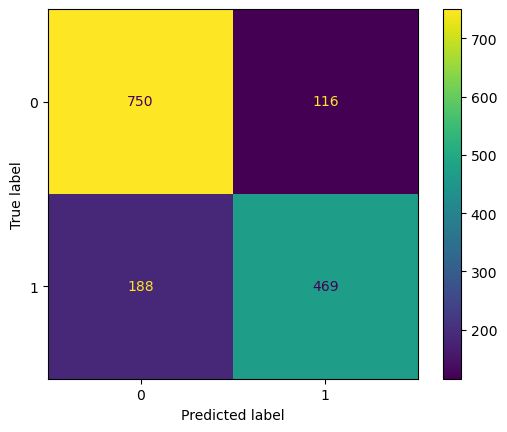

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       866
           1       0.80      0.71      0.76       657

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [137]:
#plot confusion matrix

plot_cm(lr_cv)

In [138]:
accuracy_lr,f1_lr,recall_lr,precision_lr = cal_scores(y_test,y_pred_lrcv)
print("accuracy score = ",accuracy_lr)
print("f1 score = ",f1_lr)
print("recall score = ",recall_lr)
print("precision score = ",precision_lr)

accuracy score =  0.8003939592908733
f1 score =  0.7552334943639292
recall score =  0.7138508371385084
precision score =  0.8017094017094017


### Build Decision tree model

In [140]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
dtc.score(X_train,y_train)

0.9844006568144499

In [141]:
#model score test set
dtc.score(X_test,y_test)

0.7353906762967827

In [142]:
#predict score for test set

y_pred_dtc = dtc.predict(X_test)

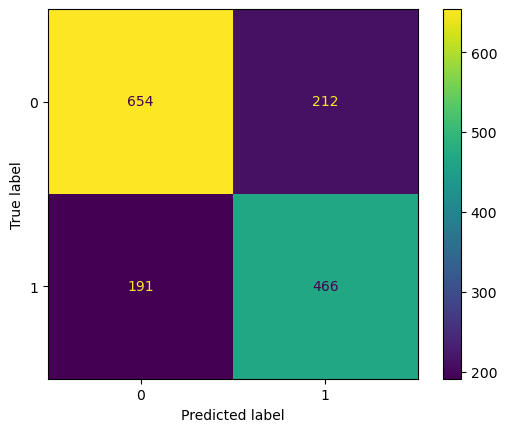

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       866
           1       0.69      0.71      0.70       657

    accuracy                           0.74      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.74      0.74      0.74      1523



In [143]:
#plot confusion matrix

plot_cm(dtc)

In [144]:
accuracy_dtc,f1_dtc,recall_dtc,precision_dtc = cal_scores(y_test,y_pred_dtc)
print("accuracy score = ",accuracy_dtc)
print("f1 score = ",f1_dtc)
print("recall score = ",recall_dtc)
print("precision score = ",precision_dtc)

accuracy score =  0.7353906762967827
f1 score =  0.6981273408239701
recall score =  0.7092846270928462
precision score =  0.6873156342182891


# Comparision of scores from the model

In [146]:
#all models
model_lists = [lr,lr_cv,dtc]
#model_name = ['lr_model','lr_cv','dtc']

In [147]:
def comp_scores(model_lst):
    score_df = pd.DataFrame()
    for i,model in enumerate(model_lists):
        y_pred = model.predict(X_test)
        accu,f1,rec,prec= cal_scores(y_test,y_pred)
        score_df[i] = [accu,f1,rec,prec]
        #print(model)
    return score_df

In [148]:
scores_df = comp_scores(model_lists)
scores_df

,0,1,2
0,0.882469,0.800394,0.735391
1,0.853878,0.755233,0.698127
2,0.796043,0.713851,0.709285
3,0.920775,0.801709,0.687316


In [149]:
#rename columns
lab = {0:'logisctic_reg',1:'log_reg_cv',2:'dtc'}
scores_df.rename(columns = lab,inplace = True)

In [150]:
#rename index to respective scores names
ind = {0:'accuracy_score',1:'f1_score',2:'recall_score',3:'precision'}
scores_df.rename(index = ind,inplace =True)

In [151]:
scores_df = scores_df.transpose()
scores_df = scores_df.reset_index()

In [152]:
scores_df

,index,accuracy_score,f1_score,recall_score,precision
0,logisctic_reg,0.882469,0.853878,0.796043,0.920775
1,log_reg_cv,0.800394,0.755233,0.713851,0.801709
2,dtc,0.735391,0.698127,0.709285,0.687316


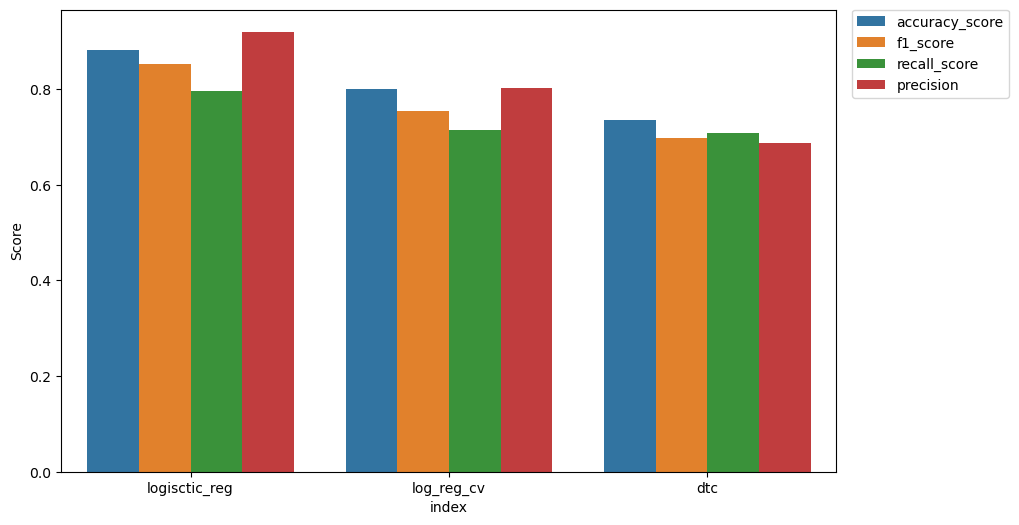

In [153]:
plt.figure(figsize=(10,6))

# melt the DataFrame to create a "long" format
df_melted = pd.melt(scores_df, id_vars=['index'], var_name='Metric', value_name='Score')

# create the bar plot
#sns.set(rc={'figure.figsize':(50,25)})
sns.barplot(data=df_melted, x='index', y='Score', hue='Metric')

#place legend outside top right corner of plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

--> Logistic Regression has the highest F1 score 
--> is the best model
--> We will use this model to predict test set

In [156]:
test_data.head()

,id,text,tags
0,0,just happened terrible car crash,just happen terribl car crash
1,2,heard earthquake different city stay safe ever...,heard earthquak differ citi stay safe everyon
2,3,forest fire spot pond goose fleeing across str...,forest fire spot pond goos flee across street ...
3,9,apocalypse lighting spokane wildfire,apocalyps light spokan wildfir
4,11,typhoon soudelor kill 28 china taiwan,typhoon soudelor kill 28 china taiwan


# Prediction using Logistic Reg model

For test set we need to use our model to output prediction 

In [158]:
#check shape of test input data

T.shape

(3263, 5000)

In [159]:
#Predict using best ML model

pred = lr.predict(T)

In [160]:
submission = pd.read_csv("test.csv")

In [161]:
#keeping only id column from submission
submission = submission[['id']]
submission

,id
0,0
1,2
2,3
3,9
4,11
...,...
3258,10861
3259,10865
3260,10868
3261,10874


In [162]:
submission['target'] = pred

In [163]:
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [164]:
submission.to_csv("submission.csv",index = False)

# **STEP 3: Evaluation**

In [17]:
# Predict on validation set and calculate accuracy
from sklearn.metrics import accuracy_score

y_pred_val = lr_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print('Validation accuracy:', val_accuracy)

Validation accuracy: 0.8003939592908733


The accuracy I got is 80%. This is my first attempt on 'Natural Language Processing', and I will definitely do better asap.

In [18]:
#Predictions on test set
y_pred_test = lr_model.predict(X_test)

In [19]:
submission = pd.DataFrame({'id': test_data['id'], 'target': y_pred_test})
submission.to_csv('submission.csv', index=False)